# Transfer Learning with Scaling-Up

> We have seen the power of transfer learning with `Feature Extraction and Fine-Tuning` of models.

> Now we would be using those models to train on the `Food101 dataset` with all the `101` food classes together.

**Food101 Dataset** -> https://www.kaggle.com/datasets/dansbecker/food-101

**Page With Code** -> https://paperswithcode.com/dataset/food-101

**Original Page** -> https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

> In the paper they used `Random Forest` and got an accuracy score of `50.76%`. 


> In this notebook, we will get a better score than the paper on only `10%` of the training data with all of the `101` classes in the dataset.  



In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.efficientnet import EfficientNetB0



## Importing helper functions

In [ ]:
!wget https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py

In [ ]:
from helper_functions import make_confusion_matrix,compare_historys, unzip_data, create_tensorboard_callback, plot_loss_curves, walk_through_dir, model_check_point_callback, create_data_augmented_layer_for_model, create_feature_extraction_model

## Getting the data

> Using only `10%` of the data with all of the `101` food classes in the dataset.

> We are getting the datasets from the original Food101 dataset but it has been preprocessed using the `image_data_modification` notebook -> https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2022-08-02 12:20:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   139MB/s    in 12s     

2022-08-02 12:20:49 (124 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
unzip_data('101_food_classes_10_percent.zip')

In [ ]:
walk_through_dir('101_food_classes_10_percent')

In [ ]:
train_dir='101_food_classes_10_percent/train'
test_dir='101_food_classes_10_percent/test'

In [ ]:
len(train_dir)

In [ ]:
IMG_SIZE= (224,224)
BATCH_SIZE=32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode="categorical", image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode="categorical", image_size=IMG_SIZE,shuffle=False)

## Creating a model with transfer learning with 10% of the 101 food classes dataset

* Create ModelCheckpoint callback
* Create Data Augmentation layer for the model
* Build a *feature extraction model* with `EfficientNet_B0` architecture and a custom output layer

### ModelCheckpoint callback

In [ ]:
file_path= '101_classes_10_percent_model_checkpoint'
model_check_point_callback=model_check_point_callback(file_path, save_weights_only=True, save_best_only=True, monitor="val_accuracy")
model_check_point_callback

### Data Augmentation Layer

In [ ]:
augmented_layer=create_data_augmented_layer_for_model(RandomFlip="horizontal", RandomRotation=0.2, RandomZoom=0.2, RandomHeight=0.2, RandomWidth=0.2)
augmented_layer

### Tensorflow Callback

In [ ]:
tensorboard_dir_name="(transfer_learning)", 
tensorboard_experiment_name="(10_percent_data_augmented_feature_extraction)"

In [ ]:
len(train_data_10_percent.class_names)

### Creating the feature-extraction model

In [ ]:
INPUT_SHAPE=(224,224,3)
CLASS_COUNT= len(train_data_10_percent.class_names)
EPOCHS=10

In [ ]:
input_shape=(224,224,3)

base_model= EfficientNetB0(include_top=False)
base_model.trainable= False

inputs= tf.keras.layers.Input(shape=input_shape, name="input_layer")

x= augmented_layer(inputs)

x= base_model(x, training=False)

x= layers.GlobalAveragePooling2D(name="global_average_pooling2D")(x)

outputs= layers.Dense(CLASS_COUNT, activation="softmax", name="output_layer")(x)

model_0= keras.Model(inputs, outputs)

model_0.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam())

history_0_10_percent= model_0.fit(train_data_10_percent, 
                                  epochs=10, steps_per_epoch=len(train_data_10_percent), 
                                  validation_data=test_data, validation_steps=int(0.15 * len(test_data)), 
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_data_augmented_feature_extraction"), model_check_point_callback])



In [ ]:
model_0.summary()

In [ ]:
model_0.evaluate(test_data)

In [ ]:
plot_loss_curves(history_0_10_percent)

> The graphs are suggesting that the `model_0` is `overfitting` on the training data. In other words, it is `not generalizing the patterns` it learns from the training data when coming across the `test/validation` data

## Fix overfitting of the model

> We could try `GlobalMaxPooling2D` instead of `GlobalAveragePooling2D` to see if it improves the overfitting issue or not.

**Docs** -> https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D

> Try `GlobalMaxPooling2D` but the accuracy(46.78%) was much worse compared to `GlobalAveragePooling2D` which was 56.21% and the overfitting issue was still.

> The values from the model trained with `GlobalMaxPooling2D`:

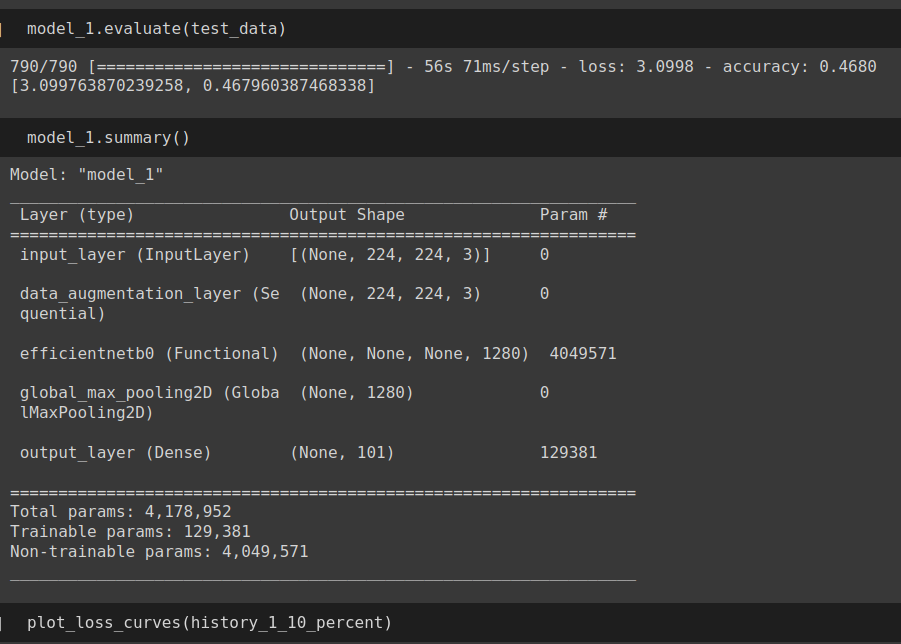


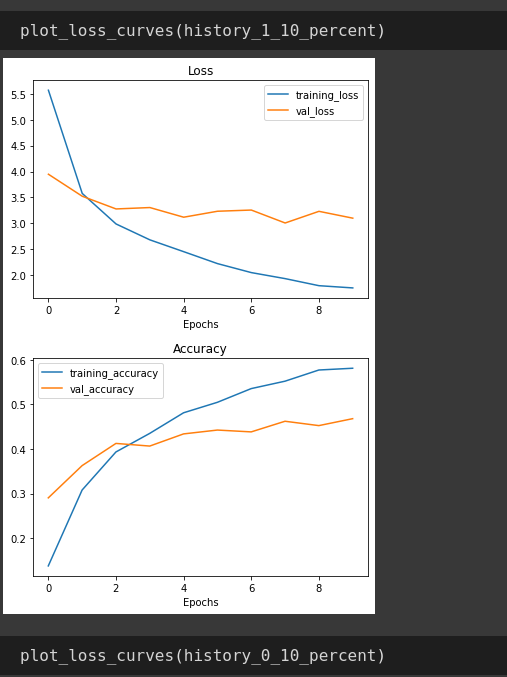

## Conclusion

> The `Dropout` layer added to the feature extraction model has helped in reducing `overfitting` of the model. After seeing the graphs of both the models, it is clear `Dropout` layers helps in reducing `overfitting` of the model.

* Model With `Dropout` layer

> **Loss** -> 1.6728649139404297, **Accuracy** -> 0.5590494871139526

* Model without `Dropout` layer
 
> **Loss** -> 1.6465145349502563, **Accuracy** -> 0.5621781945228577

 



## Finding the ideal Learning rate

### Learning Rate Callback

In [ ]:
lr_callback=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/2))

In [ ]:
input_shape=(224,224,3)

base_model= EfficientNetB0(include_top=False)
base_model.trainable= False

inputs= tf.keras.layers.Input(shape=input_shape, name="input_layer")

x= augmented_layer(inputs)

x= base_model(x, training=False)

x= layers.GlobalAveragePooling2D(name="global_average_pooling2D")(x)

# To minimize Overfitting of the model
x = tf.keras.layers.Dropout(0.5)(x)

outputs= layers.Dense(CLASS_COUNT, activation="softmax", name="output_layer")(x)

model_2= keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam())

history_2_10_percent= model_2.fit(train_data_10_percent, 
                                  epochs=10, steps_per_epoch=len(train_data_10_percent), 
                                  validation_data=test_data, validation_steps=int(0.15 * len(test_data)), 
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_data_augmented_feature_extraction"), lr_callback])



In [ ]:
lrs=1e-3 *(10**(tf.range(10)/2))
plt.semilogx(lrs, history_2_10_percent.history["loss"])
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.title("Finding the ideal learning rate")

> Let's try a learning_rate of `0.0001`

In [ ]:
input_shape=(224,224,3)

base_model= EfficientNetB0(include_top=False)
base_model.trainable= False

inputs= tf.keras.layers.Input(shape=input_shape, name="input_layer")

x= augmented_layer(inputs)

x= base_model(x, training=False)

x= layers.GlobalAveragePooling2D(name="global_average_pooling2D")(x)

# To minimize Overfitting of the model
x = tf.keras.layers.Dropout(0.5)(x)

outputs= layers.Dense(CLASS_COUNT, activation="softmax", name="output_layer")(x)

model_3= keras.Model(inputs, outputs)

model_3.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

history_3_10_percent= model_3.fit(train_data_10_percent, 
                                  epochs=10, steps_per_epoch=len(train_data_10_percent), 
                                  validation_data=test_data, validation_steps=int(0.15 * len(test_data)), 
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_data_augmented_feature_extraction")])



In [ ]:
model_3.evaluate(test_data)

In [ ]:
plot_loss_curves(history_3_10_percent)

> `0.01`  learning_rate is not the one, as the `validation_loss` is all over the place and it is increasing at the later epochs

Let's try learning rate of `0.0005` as this falls between `0.0001` and `0.001` learning rates

In [ ]:
input_shape=(224,224,3)

base_model= EfficientNetB0(include_top=False)
base_model.trainable= False

inputs= tf.keras.layers.Input(shape=input_shape, name="input_layer")

x= augmented_layer(inputs)

x= base_model(x, training=False)

x= layers.GlobalAveragePooling2D(name="global_average_pooling2D")(x)

# To minimize Overfitting of the model
x = tf.keras.layers.Dropout(0.5)(x)

outputs= layers.Dense(CLASS_COUNT, activation="softmax", name="output_layer")(x)

model_5= keras.Model(inputs, outputs)

model_5.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

history_5_10_percent= model_5.fit(train_data_10_percent, 
                                  epochs=10, steps_per_epoch=len(train_data_10_percent), 
                                  validation_data=test_data, validation_steps=int(0.15 * len(test_data)), 
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_data_augmented_feature_extraction")])



In [ ]:
model_5.evaluate(test_data)

In [ ]:
plot_loss_curves(history_5_10_percent)

## Conclusion

> From the above experiments, we can see that with the help of `Dropout` layer and changing/altering the learning rate of the optimizer has helped with lower the `overfitting` problem of the model.

> We can use either `0.0005` or `0.0001` as the learning rate value.


> `model_5` is the final feature_extraction model, we will `train it again` to `save the weights` of the model. This model will be used for `fine-tuning` later on

## Training `model_5` again to save the weights of the model

In [ ]:
input_shape=(224,224,3)

base_model= EfficientNetB0(include_top=False)
base_model.trainable= False

inputs= tf.keras.layers.Input(shape=input_shape, name="input_layer")

x= augmented_layer(inputs)

x= base_model(x, training=False)

x= layers.GlobalAveragePooling2D(name="global_average_pooling2D")(x)

# To minimize Overfitting of the model
x = tf.keras.layers.Dropout(0.5)(x)

outputs= layers.Dense(CLASS_COUNT, activation="softmax", name="output_layer")(x)

model_final= keras.Model(inputs, outputs)

model_final.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

history_final_10_percent= model_final.fit(train_data_10_percent, 
                                  epochs=10, steps_per_epoch=len(train_data_10_percent), 
                                  validation_data=test_data, validation_steps=int(0.15 * len(test_data)), 
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_data_augmented_feature_extraction_final"), model_check_point_callback])



In [ ]:
model_final.evaluate(test_data)

In [ ]:
result_final_feature_exctration= model_final.evaluate(test_data)
result_final_feature_exctration

In [ ]:
plot_loss_curves(history_final_10_percent)

## Unfreezing the last `20` layers for Fine-tuning `model_final`

* Learning Rate is `0.0005`

In [ ]:
base_model.trainable= True

for layer in base_model.layers[:-20]:
  layer.trainable= False


model_final.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005))

In [ ]:
for layer in model_final.layers[2].layers:
  if layer.trainable == True:
    print(layer, layer.name, layer.trainable)

In [ ]:
len(model_final.trainable_variables)

## Fine-Tuning `model_final` with `20` unfrozen layers

In [ ]:
inital_epochs=10
fine_tune_epochs= inital_epochs + 10

history_10_percent_20_unfrozen=model_final.fit(train_data_10_percent, epochs=fine_tune_epochs, initial_epoch= history_final_10_percent.epoch[-1], steps_per_epoch=len(train_data_10_percent), validation_data=test_data, validation_steps=int(0.15 * len(test_data)), callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_fine_tune_last_20_layers")] )

In [ ]:
model_final.evaluate(test_data)

In [ ]:
compare_historys(history_final_10_percent, history_10_percent_20_unfrozen)

> Model is `overfitting`, need to fit it.

In [ ]:
model_final.summary()

In [ ]:
result_1_fine_tuning=model_final.evaluate(test_data)
result_1_fine_tuning

In [ ]:
result_final_feature_exctration

## Saving and Loading Model

In [ ]:
model_final.save('/content/drive/MyDrive/Colab Notebooks/101_food_classes_10_percent_final_saved_model')

In [ ]:
loaded_model= tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/101_food_classes_10_percent_final_saved_model')

## Evaluate Loaded model

In [ ]:
loaded_model.evaluate(test_data)

In [ ]:
result_1_fine_tuning

## Evaluating the performance of the `model_0` across different classes

> Making some predictions, vizualizing the predictions

> In other words, every time the trained model see's an image it will compare it to all of the patterns it learned during training and return an output for every class (all 101 of them) of how likely the image is to be that class